# Image generation using GAN models

In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Check if a GPU is available and set the device accordingly
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
# Load model parameters from saved checkpoint
def load_model(model, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
        print("Checkpoint loaded successfully")
    else:
        print(f"No checkpoint found at {checkpoint_path}")

## Image generated by a simple GAN model

A simple GAN generator model trained on MNIST dataset takes a random noise vector of size 100 and generates an 28x28 grayscale fake image of a digit. The generated digit resembles to any of the actual training digits between 0 to 9.

In [4]:
# Define Generator model
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x)) 

In [5]:
# Define model and optimizer
g_input_dim = 100  # Example input dimension
g_output_dim = 784  # Example output dimension (e.g., for MNIST)
generator = Generator(g_input_dim, g_output_dim)
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# Load model from checkpoint
checkpoint_path = '../saved_models/gan_mnist_pytorch/gan_mnist_pytorch_G_epoch_200.pth'
load_model(generator, checkpoint_path)

Loading checkpoint from ../saved_models/gan_mnist_pytorch/gan_mnist_pytorch_G_epoch_200.pth
Checkpoint loaded successfully


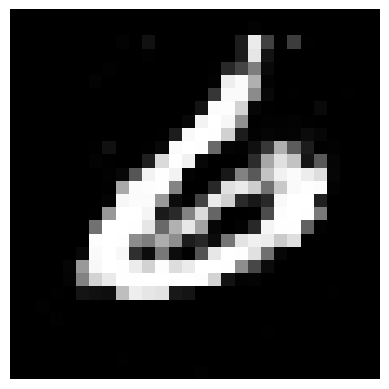

In [6]:
# Create a random noise vector z
g_input_dim = 100  # Example input dimension
z = torch.randn(1, g_input_dim)
# Generate an image using the generator
generated_image = generator(z)

# Reshape the generated image to 28x28 for visualization
generated_image = generated_image.view(generated_image.size(0), 1, 28, 28)
# Display the generated image
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(generated_image[0, 0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

## Image generation by Conditional-GAN

In [7]:
# Define a conditional generator model
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, label_dim):
        super(ConditionalGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate noise and labels
        input = torch.cat((noise, labels), dim=1)
        return self.model(input)

In [8]:
# Initialize models
noise_dim = 100
label_dim = 10  # MNIST has 10 classes (0-9)
conditionalGenerator = ConditionalGenerator(noise_dim, label_dim)
optimizer = torch.optim.Adam(conditionalGenerator.parameters(), lr=0.0002)

# Load model from checkpoint
checkpoint_path = '../saved_models/conditional_gan_mnist_pytorch/conditional_gan_generator_epoch_60.pth'
load_model(conditionalGenerator, checkpoint_path)

Loading checkpoint from ../saved_models/conditional_gan_mnist_pytorch/conditional_gan_generator_epoch_60.pth
Checkpoint loaded successfully


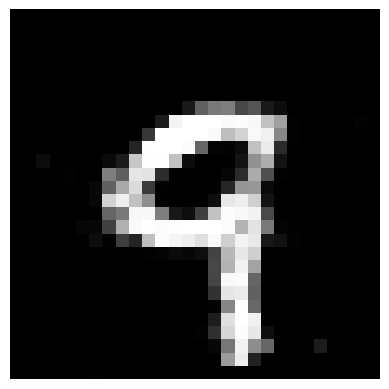

In [9]:
# Generate an image using the generator for label 5
label = torch.tensor([9], device=device)
noise = torch.randn(1, noise_dim, device=device)
label_one_hot = F.one_hot(label, num_classes=label_dim).float().to(device)

# Move the model to the correct device
conditionalGenerator = conditionalGenerator.to(device)

generated_image = conditionalGenerator(noise, label_one_hot)
# Reshape the generated image to 28x28 for visualization
generated_image = generated_image.view(generated_image.size(0), 1, 28, 28)
# Display the generated image
plt.imshow(generated_image[0, 0].detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()